# <span style="color:mediumvioletred"> **LAB 1  Optical Recognition of Handwritten Digits**</span>
### **Machine Learning**
Aissa Berenice Gonzalez Fosado 752224

<img src="https://oci02.img.iteso.mx/Identidades-De-Instancia/ITESO/Logos%20ITESO/Logo-ITESO-Principal-Gris.png"  width="300">

En este notebook se implementa un **Perceptrón de 2 capas (entrada y salida)** para reconocer dígitos escritos a mano del *Dataset Optical Recognition of Handwritten Digits* del **UCI Machine Learning Repository**.
Este dataset contiene imágenes de **8 x 8 píxeles** representando cada uno de los 10 dígitos (0–9).
El mismo dataset está disponible directamente en la librería `scikit-learn`.

La práctica incluye:

- **Perceptrón from scratch**: implementación manual en Python utilizando únicamente `NumPy`.
- **Perceptrón de scikit-learn**: usando `sklearn.linear_model.Perceptron`.
- **Red Perceptrón Multicapa (MLP)**: con una capa escondida, entrenada con `sklearn.neural_network.MLPClassifier`, mostrando además la **curva de aprendizaje (accuracy vs. épocas)**.
- **Modelo tradicional de Machine Learning** para comparación:`SVC` (Support Vector Classifier con kernel RBF).

Finalmente, se muestran los resultados de accuracy, reportes de clasificación y matrices de confusión, para analizar el desempeño de cada enfoque en la tarea de clasificación de dígitos escritos a mano.


In [28]:
# Imports librerías
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron as SkPerceptron
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
from sklearn.exceptions import ConvergenceWarning

In [21]:
# Cargar dataset digits
digits = datasets.load_digits()
X = digits.data        # shape (n_samples, 64)
y = digits.target
n_classes = len(np.unique(y))
print("Dataset shape:", X.shape, "Número de clases:", n_classes)

# División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Escalado (importante para MLP y SVC)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)


Dataset shape: (1797, 64) Número de clases: 10


In [22]:
# Perceptron multiclasificado "from scratch" (voto por score, actualización perceptron estocástica)
class PerceptronFromScratch:
    def __init__(self, n_classes, n_features, learning_rate=1.0):
        self.n_classes = n_classes
        self.n_features = n_features
        self.lr = learning_rate
        # W: (n_classes, n_features + 1) -- última columna es bias
        self.W = np.zeros((n_classes, n_features + 1), dtype=float)

    def _add_bias(self, X):
        return np.hstack([X, np.ones((X.shape[0], 1))])

    def predict(self, X):
        Xb = self._add_bias(X)
        scores = Xb.dot(self.W.T)   # (n_samples, n_classes)
        return np.argmax(scores, axis=1)

    def fit(self, X, y, epochs=10, X_val=None, y_val=None, verbose=False):
        Xb = self._add_bias(X)
        train_acc = []
        val_acc = []
        for ep in range(epochs):
            idx = np.random.permutation(Xb.shape[0])
            # actualización estocástica
            for i in idx:
                xi = Xb[i]         # (n_features + 1,)
                yi = y[i]
                scores = self.W.dot(xi)
                pred = np.argmax(scores)
                if pred != yi:
                    # promover la clase correcta, degradar la predicha
                    self.W[yi] += self.lr * xi
                    self.W[pred] -= self.lr * xi
            # medición por época
            train_pred = self.predict(X)
            train_acc.append(accuracy_score(y, train_pred))
            if X_val is not None and y_val is not None:
                val_pred = self.predict(X_val)
                val_acc.append(accuracy_score(y_val, val_pred))
            if verbose:
                if X_val is not None:
                    print(f"Epoch {ep+1}/{epochs} - train: {train_acc[-1]:.4f}, val: {val_acc[-1]:.4f}")
                else:
                    print(f"Epoch {ep+1}/{epochs} - train: {train_acc[-1]:.4f}")
        return train_acc, val_acc


In [23]:
# Entrenar Perceptron from-scratch
per_scratch = PerceptronFromScratch(n_classes=n_classes, n_features=X_train_s.shape[1], learning_rate=1.0)
epochs = 30
train_acc_scratch, val_acc_scratch = per_scratch.fit(
    X_train_s, y_train, epochs=epochs, X_val=X_test_s, y_val=y_test, verbose=False
)

y_pred_scratch = per_scratch.predict(X_test_s)
acc_scratch = accuracy_score(y_test, y_pred_scratch)
print("Perceptron from scratch - Test accuracy:", acc_scratch)

# Entrenar Perceptron de sklearn
skp = SkPerceptron(random_state=42, max_iter=1000, tol=1e-3)
skp.fit(X_train_s, y_train)
y_pred_skp = skp.predict(X_test_s)
acc_skp = accuracy_score(y_test, y_pred_skp)
print("sklearn Perceptron - Test accuracy:", acc_skp)


Perceptron from scratch - Test accuracy: 0.9333333333333333
sklearn Perceptron - Test accuracy: 0.9333333333333333


In [30]:
# MLPClassifier: usar warm_start + max_iter=1 para "simular" épocas y guardar accuracy por época
mlp = MLPClassifier(hidden_layer_sizes=(64,), activation='relu', solver='adam',
                    warm_start=True, max_iter=1, random_state=42)

train_acc_mlp = []
val_acc_mlp = []
n_epochs = 30
for ep in range(n_epochs):
    mlp.fit(X_train_s, y_train)   # con warm_start=True y max_iter=1 avanza 1 época
    train_acc_mlp.append(accuracy_score(y_train, mlp.predict(X_train_s)))
    val_acc_mlp.append(accuracy_score(y_test, mlp.predict(X_test_s)))

y_pred_mlp = mlp.predict(X_test_s)
acc_mlp = accuracy_score(y_test, y_pred_mlp)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
print("MLP - Test accuracy:", acc_mlp)


MLP - Test accuracy: 0.9805555555555555


In [25]:
# SVC (RBF)
svc = SVC(kernel='rbf', gamma='scale', random_state=42)
svc.fit(X_train_s, y_train)
y_pred_svc = svc.predict(X_test_s)
acc_svc = accuracy_score(y_test, y_pred_svc)
print("SVC (RBF) - Test accuracy:", acc_svc)

# Random Forest (puede usar datos sin escalar)
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest - Test accuracy:", acc_rf)


SVC (RBF) - Test accuracy: 0.975
Random Forest - Test accuracy: 0.9638888888888889


In [26]:
# Tabla de resultados
results = pd.DataFrame({
    "model": ["Perceptron_from_scratch", "sklearn_Perceptron", "MLP", "SVC", "RandomForest"],
    "test_accuracy": [acc_scratch, acc_skp, acc_mlp, acc_svc, acc_rf]
}).sort_values("test_accuracy", ascending=False).reset_index(drop=True)

print("Resultados ordenados por test accuracy:\n")
print(results)

# Informes detallados
preds = {
    "Perceptron_from_scratch": y_pred_scratch,
    "sklearn_Perceptron": y_pred_skp,
    "MLP": y_pred_mlp,
    "SVC": y_pred_svc,
    "RandomForest": y_pred_rf
}

# Elegir mejor modelo
best_model = results.loc[0, "model"]
best_pred = preds[best_model]
print(f"\nMejor modelo: {best_model} (accuracy = {results.loc[0, 'test_accuracy']:.4f})\n")

print("Classification report del mejor modelo:\n")
print(classification_report(y_test, best_pred))

cm = confusion_matrix(y_test, best_pred)
print("Confusion matrix (filas=verdad, columnas=pred):\n", cm)

# Per-class accuracy
per_class_acc = np.diag(cm) / np.bincount(y_test)
class_acc_df = pd.DataFrame({"class": np.arange(n_classes), "accuracy": per_class_acc})
print("\nPer-class accuracy del mejor modelo:\n", class_acc_df)


Resultados ordenados por test accuracy:

                     model  test_accuracy
0                      MLP       0.980556
1                      SVC       0.975000
2             RandomForest       0.963889
3  Perceptron_from_scratch       0.933333
4       sklearn_Perceptron       0.933333

Mejor modelo: MLP (accuracy = 0.9806)

Classification report del mejor modelo:

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        36
           1       0.92      0.97      0.95        36
           2       0.97      1.00      0.99        35
           3       1.00      0.97      0.99        37
           4       1.00      0.97      0.99        36
           5       1.00      1.00      1.00        37
           6       0.97      1.00      0.99        36
           7       0.97      1.00      0.99        36
           8       1.00      0.91      0.96        35
           9       0.97      1.00      0.99        36

    accuracy                  

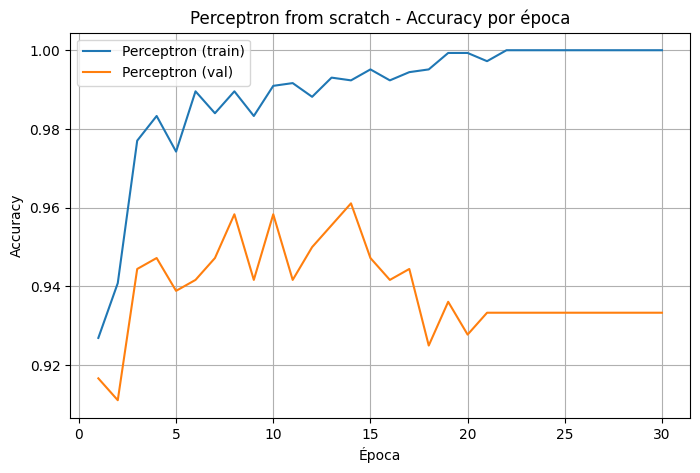

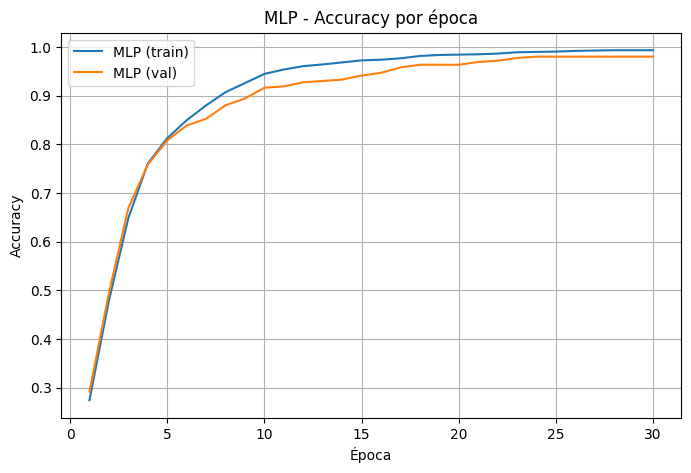

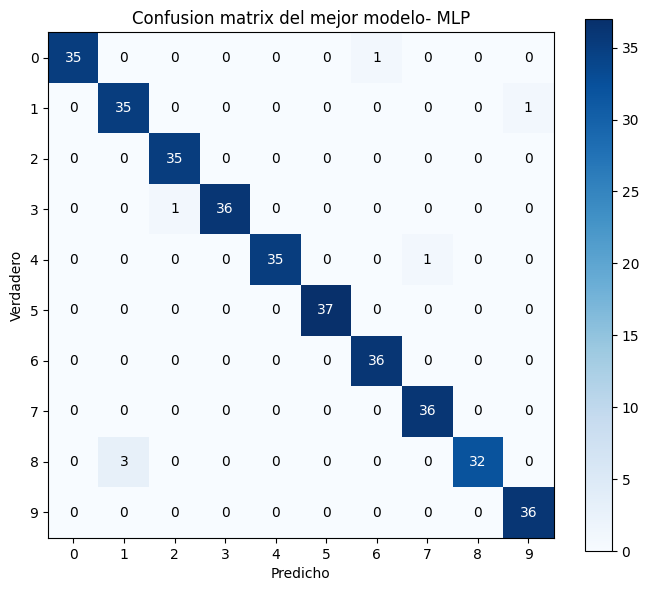

In [31]:
# Curvas de aprendizaje
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), train_acc_scratch, label="Perceptron (train)")
plt.plot(range(1, epochs+1), val_acc_scratch, label="Perceptron (val)")
plt.title("Perceptron from scratch - Accuracy por época")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(1, n_epochs+1), train_acc_mlp, label="MLP (train)")
plt.plot(range(1, n_epochs+1), val_acc_mlp, label="MLP (val)")
plt.title("MLP - Accuracy por época")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Matriz de confusión (mejor modelo) como heatmap simple
plt.figure(figsize=(7,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(f'Confusion matrix del mejor modelo- {best_model}')
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.ylabel('Verdadero')
plt.xlabel('Predicho')

# Añadir anotaciones numéricas
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()
